In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm
import scipy

# plotting stuff 

In [3]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [4]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [5]:
def plot_hydrograph(ds_combined, ax, summary_stat):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat=summary_stat).values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat=summary_stat).values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat=summary_stat).plot(ax=ax, color="C1",lw=0.5,label=f"NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [6]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        axs[i+1].fill_between(ds_combined.time, 
                         ds_combined[var].sel(summary_stat="min").values,
                         ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(var_names[var])
        axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

In [7]:
path = Path.cwd() 
figure_path = path / "Figures"

# loading

### DA best ensemble member

In [8]:
best_ds_files = list((path.parent.parent.parent / "run_experiment_best" / 'Output').glob("*.nc"))

In [9]:
best_ds_lst = []
for file in best_ds_files:
    best_ds_lst.append(xr.open_dataset(file))

In [10]:
# def calc_residuals(df, catchment):
#     ds_lst = []
#     ds = xr.open_dataset(df.loc[catchment]['path_DA'])
#     ds_lst.append(ds)
    
#     ds = xr.open_dataset(df.loc[catchment]['path_cal'])
#     ds_lst.append(ds)
#     if ds.EnsembleMember.size == 2 :
#         if len(set(ds.EnsembleMember.to_numpy())) == 1:
#             ds = ds.sel(EnsembleMember=ds.attrs['i_NSE_max']).values[0]
#         else:
#             ds = ds.sel(EnsembleMember=ds.attrs['i_NSE_max']).values
#     else:
#         pass
    
#     ds0 = ds_lst[0]
#     ds1 = ds_lst[1]
#     ds0_NSE = ds0.sel(summary_stat='best')
#     ds0_NSE['Q_res'] = ('time', (ds0_NSE['Q_obs'].to_numpy() -  ds0_NSE['Q'].to_numpy()))

#     if ds1.EnsembleMember.size == 1:
#         ds1_NSE = ds1
        
#     elif ds1.EnsembleMember.size == 2 :
#         if len(set(ds1.EnsembleMember.to_numpy())) == 1:
#             ds1_NSE = ds1.isel(EnsembleMember=0)
#         else:
#             ds1_NSE = ds1.sel(EnsembleMember=ds1.attrs['i_NSE_max'])
            
#     ds1_NSE['Q_res'] = ('time', (ds1_NSE['Q_obs'].to_numpy() -  ds1_NSE['Q'].to_numpy()))

#     DA_sum_res = np.sum(ds0_NSE['Q_res'].to_numpy()**2)
#     cal_sum_res = np.sum(ds1_NSE['Q_res'].to_numpy()**2)

#     return DA_sum_res, cal_sum_res

In [11]:
df_best = pd.DataFrame(columns=["NSE_mean_DA","log_NSE_mean_DA","NSE_best_DA","log_NSE_best_DA","path_DA"],)
for index, ds in enumerate(best_ds_lst):
    uid = ds.attrs['HRU_id']
    df_best.loc[uid, 'NSE_mean_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'log_NSE_mean_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'NSE_best_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid, 'log_NSE_best_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid,'path_DA'] = best_ds_files[index]
    df_best.loc[uid,'Q_spread'] = ((ds["Q"].sel(summary_stat='max') - ds["Q"].sel(summary_stat='min'))/ds["Q"].sel(summary_stat='mean')).mean().values 
    df_best.loc[uid, 'DA_sse'] = (np.sum((ds['Q_obs'].to_numpy() -  ds['Q'].to_numpy())**2))

In [12]:
df_best.head(3)

NSE_mean_DA log_NSE_mean_DA NSE_best_DA log_NSE_best_DA  \
01013500     0.57813        -0.55511    0.861828        0.662818   
01022500    0.521113        0.541622    0.655206        0.706836   
01030500     0.15002        0.319357    0.412902        0.476651   

                                                    path_DA  Q_spread  \
01013500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  2.104850   
01022500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  0.488813   
01030500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  0.776405   

                DA_sse  
01013500   8981.288248  
01022500  16904.200687  
01030500  13046.231415

In [13]:
# df_best.hist

In [14]:
len(df_best)

670

### calibration

In [15]:
callibration_ds_files = list((path.parent.parent.parent / "run_callibration" / 'Output').glob("*.nc"))

In [16]:
cal_ds_lst = []
for file in callibration_ds_files:
    cal_ds_lst.append(xr.open_dataset(file))

In [17]:
cal_ds_lst[0]

<xarray.Dataset>
Dimensions:         (EnsembleMember: 2, time: 1857)
Coordinates:
  * EnsembleMember  (EnsembleMember) int64 308 443
  * time            (time) datetime64[ns] 1997-08-01 1997-08-02 ... 2002-08-31
Data variables: (12/16)
    Imax            (EnsembleMember, time) float64 ...
    Ce              (EnsembleMember, time) float64 ...
    Sumax           (EnsembleMember, time) float64 ...
    Beta            (EnsembleMember, time) float64 ...
    Pmax            (EnsembleMember, time) float64 ...
    Tlag            (EnsembleMember, time) float64 ...
    ...              ...
    Su              (EnsembleMember, time) float64 ...
    Sf              (EnsembleMember, time) float64 ...
    Ss              (EnsembleMember, time) float64 ...
    Sp              (EnsembleMember, time) float64 ...
    Q               (EnsembleMember, time) float64 ...
    Q_obs           (time) float64 ...
Attributes:
    title:          HBV storage & parameter terms data over time for 500 part...
    history:        Storage term results from ewatercycle_HBV.model
    n_particles:    500
    HRU_id:         01013500
    NSE_max:        0.8000585706940022
    log_NSE_max:    0.7713077092046793
    i_NSE_max:      308
    i_log_NSE_max:  443

## combine

In [18]:
df_cal = pd.DataFrame(columns=["NSE_cal","log_NSE_cal","path_cal"]+[f'cal_{param}' for param in param_names])
for index, ds in enumerate(cal_ds_lst):
    uid = ds.attrs['HRU_id']
    df_cal.loc[uid, 'NSE_cal'] = ds.attrs['NSE_max']
    df_cal.loc[uid, 'log_NSE_cal'] = ds.attrs['log_NSE_max']
    df_cal.loc[uid,'path_cal'] = callibration_ds_files[index]
    if ds.EnsembleMember.size == 2 :
        if len(set(ds.EnsembleMember.to_numpy())) == 1:
            ds = ds.sel(EnsembleMember=ds.attrs['i_NSE_max']).isel(EnsembleMember=0) 
        else:
            ds = ds.sel(EnsembleMember=ds.attrs['i_NSE_max'])
    else:
        ds = ds

    sse = np.sum((ds['Q_obs'].to_numpy() -  ds['Q'].to_numpy())**2)
    df_cal.loc[uid,'cal_sse'] = sse

    if len(ds["Imax"].coords) == 2:
        param_series = ds.isel(time=0)[param_names].to_pandas()
    else:
        param_series = ds[param_names].to_pandas()

    for param in param_names:
        df_cal.loc[uid, f'cal_{param}'] = param_series[param]

In [19]:
df_cal.head(3)

NSE_cal log_NSE_cal  \
01013500  0.800059    0.771308   
01022500  0.640479    0.790192   
01030500  0.437132    0.631559   

                                                   path_cal  cal_Imax  \
01013500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  4.749672   
01022500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  3.821724   
01030500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  4.218451   

            cal_Ce   cal_Sumax  cal_Beta  cal_Pmax cal_Tlag    cal_Kf  \
01013500  0.593942  329.779842  2.868787  0.273734     10.0  0.082978   
01022500   0.52545  505.139245  2.059477  0.187887      2.0  0.097691   
01030500  0.243444  473.511422  0.739878  0.126805      4.0  0.042314   

            cal_Ks    cal_FM      cal_sse  
01013500  0.008492  2.464693  1176.592277  
01022500  0.002373  5.228658  3243.565825  
01030500  0.007405  5.797163  1971.440159

In [20]:
df_cal.head(3)

NSE_cal log_NSE_cal  \
01013500  0.800059    0.771308   
01022500  0.640479    0.790192   
01030500  0.437132    0.631559   

                                                   path_cal  cal_Imax  \
01013500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  4.749672   
01022500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  3.821724   
01030500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  4.218451   

            cal_Ce   cal_Sumax  cal_Beta  cal_Pmax cal_Tlag    cal_Kf  \
01013500  0.593942  329.779842  2.868787  0.273734     10.0  0.082978   
01022500   0.52545  505.139245  2.059477  0.187887      2.0  0.097691   
01030500  0.243444  473.511422  0.739878  0.126805      4.0  0.042314   

            cal_Ks    cal_FM      cal_sse  
01013500  0.008492  2.464693  1176.592277  
01022500  0.002373  5.228658  3243.565825  
01030500  0.007405  5.797163  1971.440159

In [45]:
len(df_cal)

670

In [46]:
indexes = list(set(df_cal.index).intersection(df_best.index))

In [48]:
df_cal_common = df_cal.loc[indexes]
df_best_common = df_best.loc[indexes]

In [50]:
df = pd.concat([df_cal_common,df_best_common],axis=1)
df_all = df.copy()
len_df_all = len(df)
df = df[(df['NSE_cal'] > 0 ) & (df['NSE_best_DA'] > 0 ) ] # & (df['log_NSE_mean_DA'] > 0 )& (df['log_NSE_mean_DA'] > 0 )]
df['NSE_delta_mean'] = df['NSE_mean_DA'] - df['NSE_cal']
df['NSE_delta_best'] = df['NSE_best_DA'] - df['NSE_cal']
df['log_NSE_delta_mean'] = df['log_NSE_mean_DA'] - df['log_NSE_cal']
df['log_NSE_delta_best'] = df['log_NSE_best_DA'] - df['log_NSE_cal']

In [51]:
columns_no_path = list(df.columns.copy())
columns_no_path.remove('path_DA')
columns_no_path.remove('path_cal')

In [52]:
df[columns_no_path].to_feather('DA_vs_calibrated.feather')

In [53]:
df_all['NSE_delta_mean'] = df_all['NSE_mean_DA'] - df_all['NSE_cal']
df_all['NSE_delta_best'] = df_all['NSE_best_DA'] - df_all['NSE_cal']
df_all['log_NSE_delta_mean'] = df_all['log_NSE_mean_DA'] - df_all['log_NSE_cal']
df_all['log_NSE_delta_best'] = df_all['log_NSE_best_DA'] - df_all['log_NSE_cal']
columns_no_path_all = list(df_all.columns.copy())
columns_no_path_all.remove('path_DA')
columns_no_path_all.remove('path_cal')
df_all[columns_no_path_all].to_feather('DA_vs_calibrated_all.feather')

In [240]:
((df['cal_sse'] - df['DA_sse'])).sort_values()

12147600   -998531.611645
12040500   -779958.827584
12056500   -487356.216192
12041200   -468301.756406
14400000   -418242.573866
                ...      
09447800      -767.826942
10242000      -726.446444
09510200      -643.204645
10258500      -565.896163
10259200      -464.600471
Length: 574, dtype: float64

## plots

In [195]:
df.head(1)

NSE_cal log_NSE_cal  \
06910800  0.20643     0.56253   

                                                   path_cal  cal_Imax  \
06910800  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  5.815134   

           cal_Ce   cal_Sumax  cal_Beta  cal_Pmax cal_Tlag    cal_Kf  ...  \
06910800  0.52161  603.432842  2.048814  0.056202      1.0  0.091362  ...   

         log_NSE_mean_DA NSE_best_DA  log_NSE_best_DA  \
06910800       -0.000665    0.156938         0.192414   

                                                    path_DA  Q_spread  \
06910800  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  1.024507   

             DA_rmse NSE_delta_mean NSE_delta_best  log_NSE_delta_mean  \
06910800  193.985131      -0.169325      -0.049491           -0.563196   

          log_NSE_delta_best  
06910800           -0.370116  

[1 rows x 24 columns]

In [94]:
def plot(y_var):
    n = 9
    fig, axs = plt.subplots(3,3,figsize=(10,8),sharey=True)
    axs = axs.flatten()
    df_plot = df[df[y_var] > 0]
    
    fig.suptitle(f'$\Delta$NSE vs calibrated parameters for {len(df_plot)} catchments')
    
    for i, param in enumerate(param_names):
        ax = axs[i]
        df_plot.plot.scatter(f'cal_{param}',y_var,ax=ax,color=f'C{i}')
        ax.set_xlabel(param)
        ax.set_ylabel("$\Delta$NSE")
        # ax.set_title()
        # ax.set_ylim(-0.25,1.25)
        if i == 0:
            print(ax.get_ylim())
    
    fig.tight_layout()
    fig.savefig(figure_path / f'parameters_vs_{y_var}.png',bbox_inches='tight',dpi=150)

(-0.04884456365513008, 1.0298525990311924)


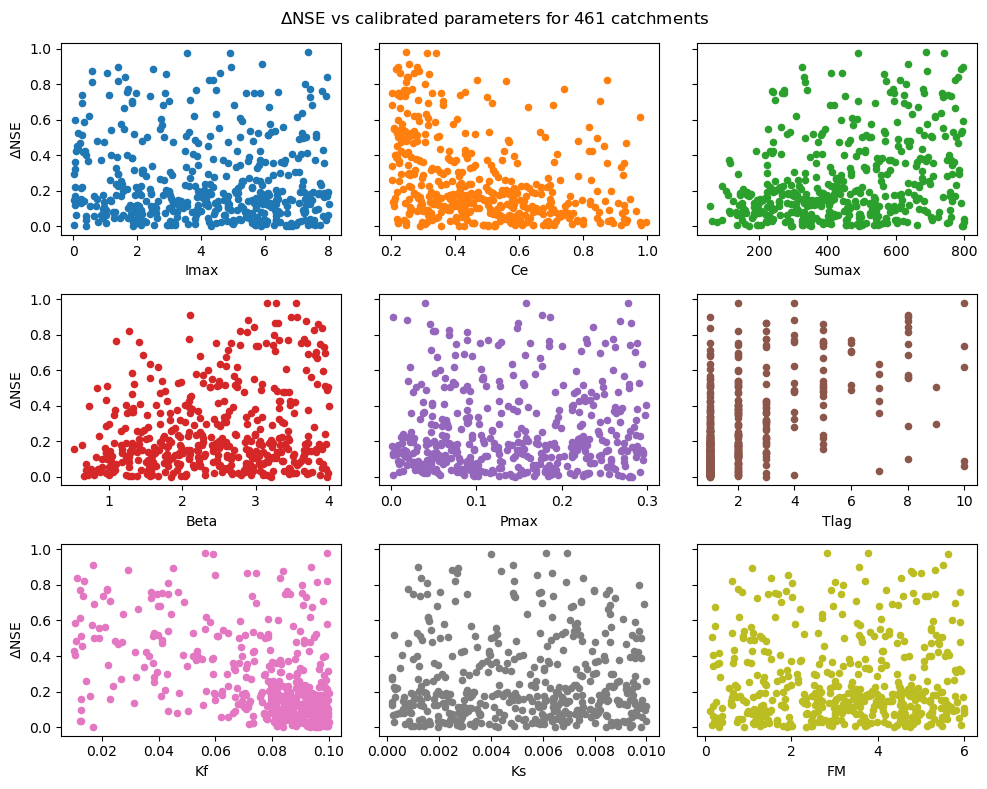

In [28]:
plot('NSE_delta_best')

(-0.0032949304642382105, 0.06995635815136023)


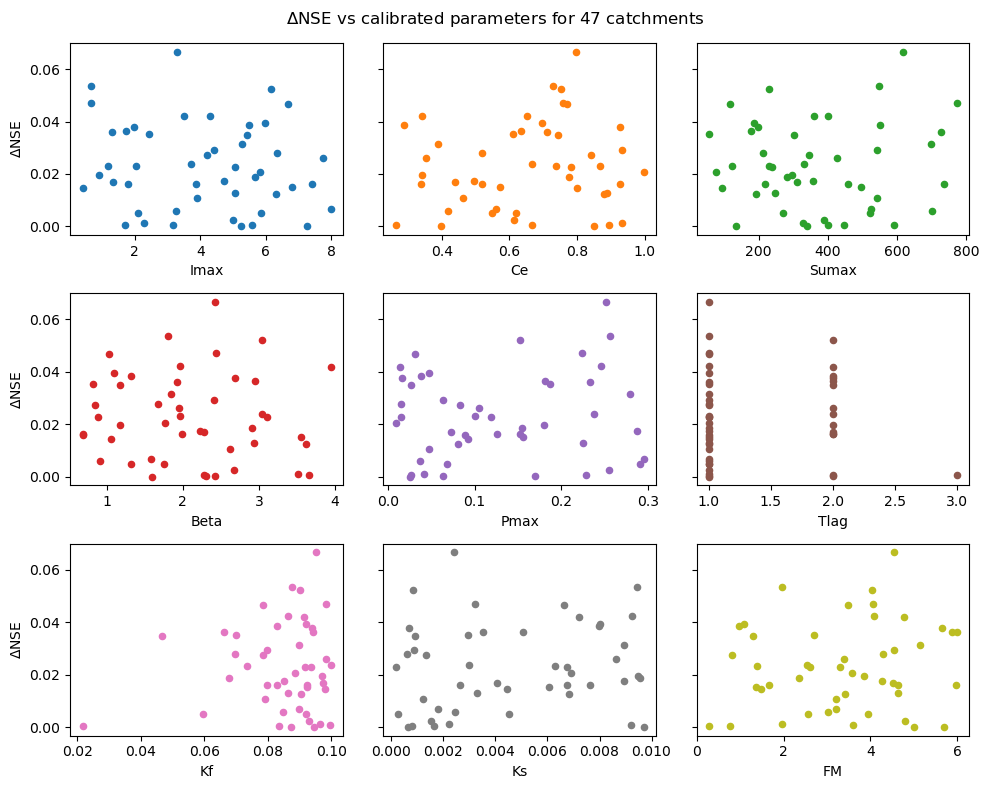

In [29]:
plot('NSE_delta_mean')

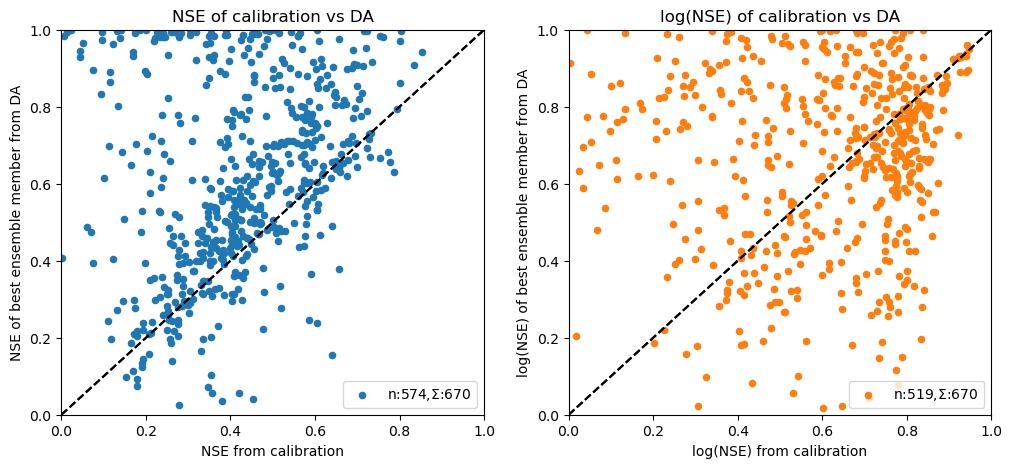

In [30]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
label = f"n:{len(df[(df['NSE_cal'] > 0 ) & (df['NSE_best_DA'] > 0 )])},$\Sigma$:{len_df_all}"
df.plot.scatter('NSE_cal','NSE_best_DA',ax=ax,color="C0",label=label)
ax.set_xlabel("NSE from calibration")
ax.set_ylabel("NSE of best ensemble member from DA")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--")
ax.legend()
ax.set_title('NSE of calibration vs DA')

ax = axs[1]
label = f"n:{len(df[(df['log_NSE_cal'] > 0 ) & (df['log_NSE_best_DA'] > 0 )])},$\Sigma$:{len_df_all}"
df.plot.scatter('log_NSE_cal','log_NSE_best_DA',ax=ax,color="C1",label=label)
ax.set_xlabel("log(NSE) from calibration")
ax.set_ylabel("log(NSE) of best ensemble member from DA")
ax.set_title('log(NSE) of calibration vs DA')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--");

fig.savefig(figure_path / 'NSE_comparison.png',bbox_inches='tight',dpi=150)

Text(0.5, 1.0, 'NSE of calibration vs DA')

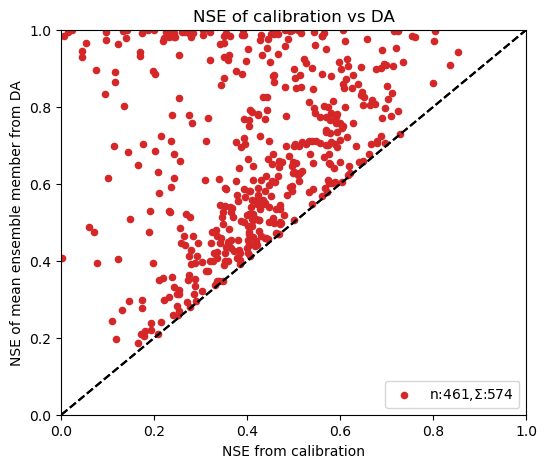

In [31]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

df_better = df[(df['NSE_cal']  < df['NSE_best_DA'])]
label = f"n:{len(df_better)},$\Sigma$:{len(df)}"
df_better.plot.scatter('NSE_cal','NSE_best_DA',ax=ax,color="C3",label=label)
ax.set_xlabel("NSE from calibration")
ax.set_ylabel("NSE of mean ensemble member from DA")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--")
ax.legend()
ax.set_title('NSE of calibration vs DA')

# specfic plots

In [148]:
def generate_plots(df, catchment):
    fig, axs = plt.subplots(2,1, figsize=(10,5),sharex=True)
    
    ds_lst = []
    ax = axs[0]
    ds = xr.open_dataset(df.loc[catchment]['path_DA'])
    ds_lst.append(ds)
    ax = plot_hydrograph(ds, ax, 'best')
    ax.legend(title=ds.attrs['HRU_id'],bbox_to_anchor=(1,1))
    
    ax = axs[1]
    ds = xr.open_dataset(df.loc[catchment]['path_cal'])
    ds_lst.append(ds)
    if ds.EnsembleMember.size == 2 :
        if len(set(ds.EnsembleMember.to_numpy())) == 1:
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_NSE_max']).values[0],color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")    
        else:
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_NSE_max']).values,color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")    
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_log_NSE_max']).values,color="C0",label=f"logNSE:{ds.attrs['log_NSE_max']:.2f}")
    else:
        ax.plot(ds["Q"].time.values, ds["Q"].values,color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")  


    ds["Q_obs"].plot(ax=ax,color='k',lw=0,marker='.')
    ax.legend(title=ds.attrs['HRU_id'],bbox_to_anchor=(1,1))
    ax.set_title('Callibrated HBV model using 500 Monte Carlo simulations')
    
    fig.tight_layout()
    return fig, ds_lst

In [149]:
def plot_residuals(ds_lst, diff=False):
    ds0 = ds_lst[0]
    ds1 = ds_lst[1]
    ds0_NSE = ds0.sel(summary_stat='best')
    ds0_NSE['Q_res'] = ('time', (ds0_NSE['Q_obs'].to_numpy() -  ds0_NSE['Q'].to_numpy()))

    if ds1.EnsembleMember.size == 1:
        ds1_NSE = ds1
        
    elif ds1.EnsembleMember.size == 2 :
        if len(set(ds1.EnsembleMember.to_numpy())) == 1:
            ds1_NSE = ds1.isel(EnsembleMember=0)
        else:
            ds1_NSE = ds1.sel(EnsembleMember=ds1.attrs['i_NSE_max'])
            
    ds1_NSE['Q_res'] = ('time', (ds1_NSE['Q_obs'].to_numpy() -  ds1_NSE['Q'].to_numpy()))

    if diff: 
        n = 2
        fig, axs = plt.subplots(n,1, figsize=(10,5),sharex=True,sharey=True)
        ax = axs[0]
    else: 
        n = 1
        fig, ax = plt.subplots(n,1, figsize=(10,2.5),sharex=True,sharey=True)
    
    common_kwargs = {'lw':0, 'marker':"."}
    
    
    ds0_NSE['Q_res'].plot(ax=ax,**common_kwargs,label=f"Data assimilated:∑={np.sum(ds0_NSE['Q_res'].to_numpy()**2):.2f}",color='C1')
    ax.axhline(0,color='k')
    ax.set_xlabel(None)

    ds1_NSE['Q_res'].plot(ax=ax,**common_kwargs,label=f"Callibrated:∑={np.sum(ds1_NSE['Q_res'].to_numpy()**2):.2f}",color='C2',zorder=-1)
    ax.legend()
    ax.set_title('Residual for DA & Callibrated ')
    ax.set_ylabel('Residuals: Obs - M')

    if diff: 
        ax = axs[1]
        (ds1_NSE['Q_res'] - ds0_NSE['Q_res']).plot(ax=ax,**common_kwargs,color='C4')
        ax.axhline(0,color='k')
        ax.set_title('Difference: DA - Callibrated ')
        ax.set_ylabel('squared Residuals')
    
    
    fig.tight_layout()
    return fig, [ds0, ds1_NSE]

In [244]:
def plot_params(names, ds_lst, ax):
    min_max_kwargs = dict(color=f"grey",lw=1,ls='--')
    for i, param in enumerate(names): 
        if param is None:
            ax[i].axis('off');
        else:
            ds_lst[0][param].sel(summary_stat='best').plot(ax=ax[i],color=f"C{i}",lw=0.5,label='Best DA')
            ds_lst[0][param].sel(summary_stat='min').plot(ax=ax[i],label='min/max', **min_max_kwargs)
            ds_lst[0][param].sel(summary_stat='max').plot(ax=ax[i],**min_max_kwargs)
            
            if ds_lst[1][param].size==1:
                ax[i].axhline(ds_lst[1][param],color='k',label='Calibrated')
            else:
                ds_lst[1][param].plot(ax=ax[i],color='k',label='Calibrated')
            ax[i].set_title(param)
            if i in [8]:
                ax[i].set_ylabel('Number of catchments')
                ax[i].legend(bbox_to_anchor=(1,1))


In [245]:
def plot_params_slope(ds_combined, params, ax, regress=False):
    for j, parameter in enumerate(params):
        ax = axs[j]
        n_particles = ds_combined.attrs['n_particles']
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="k", label="mean")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.75, color=f"C{j}")
        ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
        ax.set_ylabel(f'[{units[param_names[j]]}]')
        if j == 0: 
            ax.legend()

        if regress:
            x = range(len(ds_combined.time))
            result = scipy.stats.linregress(x, ds_combined[parameter].sel(summary_stat='mean').to_numpy())
            y = result.slope * x + result.intercept
            ax.plot(ds_combined.time, y, color="w",label=f"R$^2$={result.rvalue**2:.2f}")
            slope_text = '$m_{std}=$'
            ax.legend(title=f'{slope_text}{result.slope*365/y.mean():.4f}')

In [246]:
def generate_plots(df, catchment):
    fig, axs = plt.subplots(2,1, figsize=(10,5),sharex=True)
    
    ds_lst = []
    ax = axs[0]
    ds = xr.open_dataset(df.loc[catchment]['path_DA'])
    ds_lst.append(ds)
    ax = plot_hydrograph(ds, ax, 'best')
    ax.legend(title=ds.attrs['HRU_id'],bbox_to_anchor=(1,1))
    
    ax = axs[1]
    ds = xr.open_dataset(df.loc[catchment]['path_cal'])
    ds_lst.append(ds)
    if ds.EnsembleMember.size == 2 :
        if len(set(ds.EnsembleMember.to_numpy())) == 1:
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_NSE_max']).values[0],color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")    
        else:
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_NSE_max']).values,color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")    
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_log_NSE_max']).values,color="C0",label=f"logNSE:{ds.attrs['log_NSE_max']:.2f}")
    else:
        ax.plot(ds["Q"].time.values, ds["Q"].values,color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")  


    ds["Q_obs"].plot(ax=ax,color='k',lw=0,marker='.')
    ax.legend(title=ds.attrs['HRU_id'],bbox_to_anchor=(1,1))
    ax.set_title('Callibrated HBV model using 500 Monte Carlo simulations')
    
    fig.tight_layout()
    return fig, ds_lst

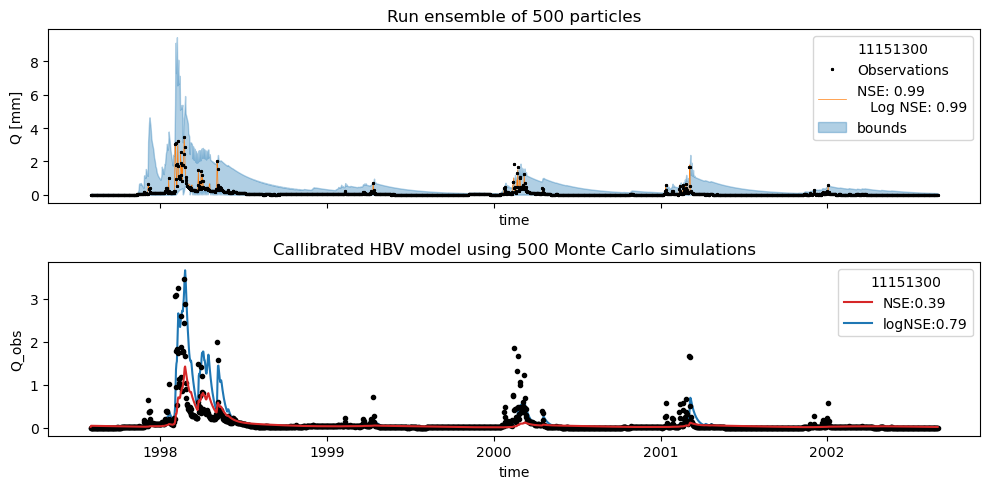

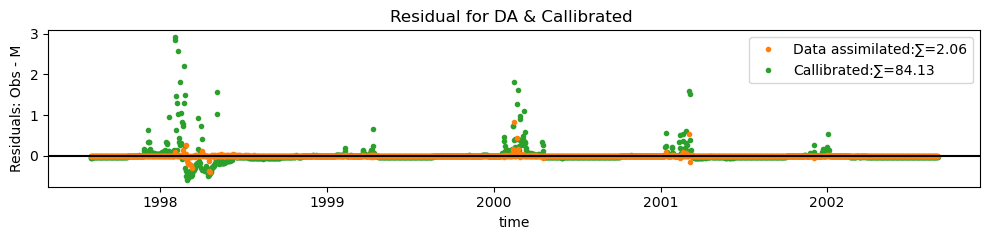

In [247]:
# 
fig, ds_lst = generate_plots(df, '11151300')
fig = plot_residuals(ds_lst)

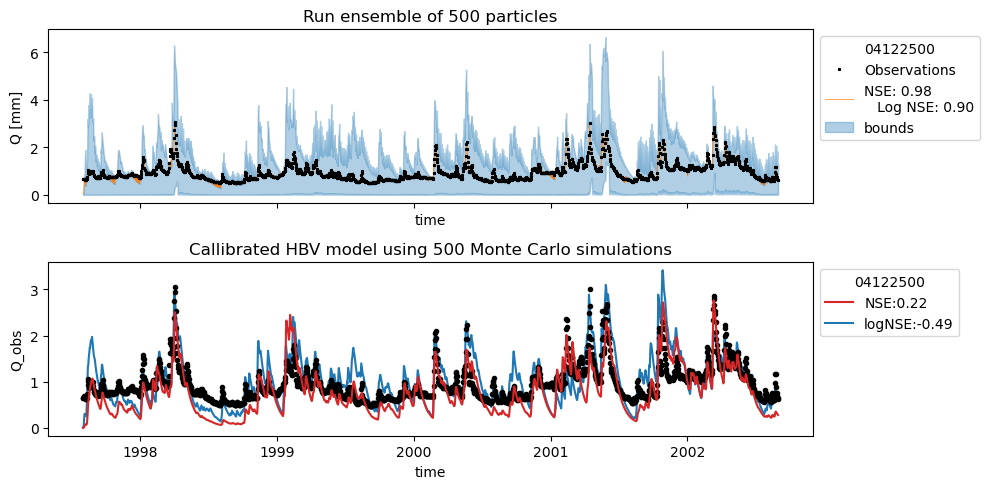

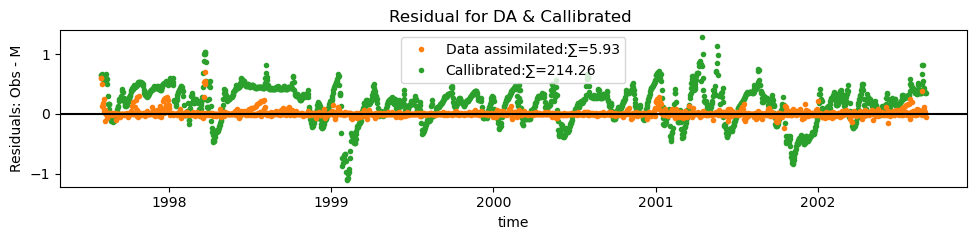

In [248]:
fig, ds_lst = generate_plots(df, '04122500')
fig = plot_residuals(ds_lst)

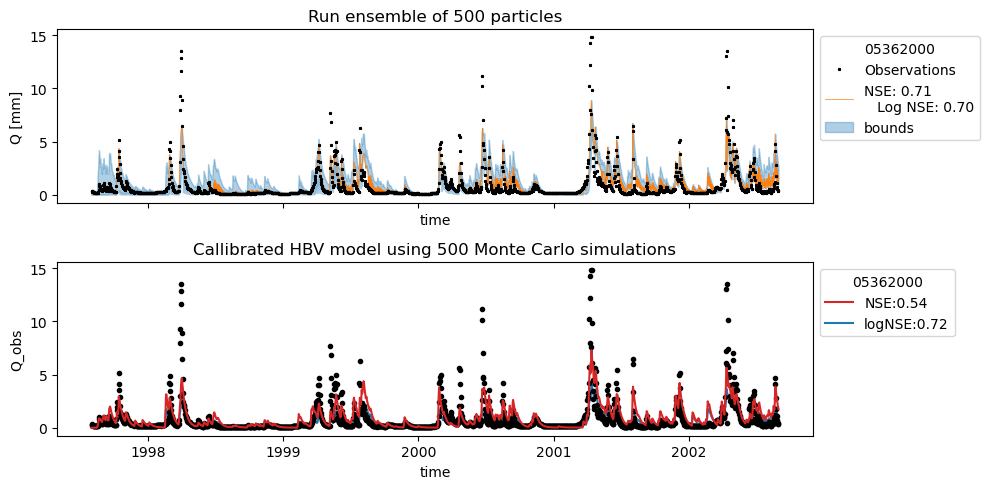

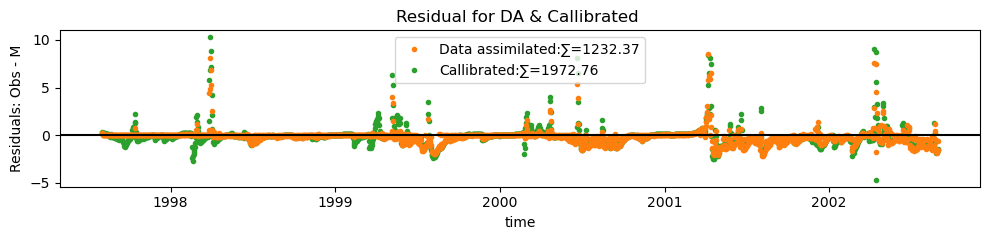

In [249]:
fig, ds_lst = generate_plots(df, '05362000')
fig = plot_residuals(ds_lst)

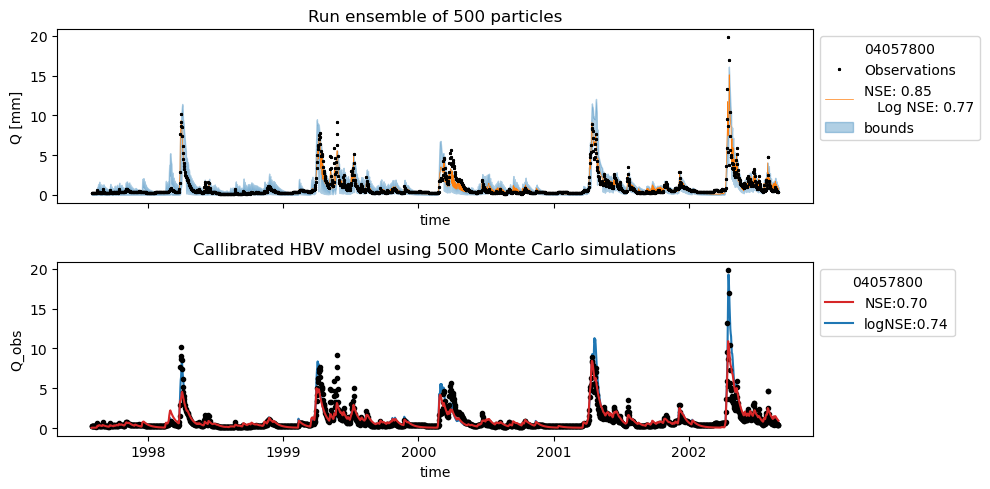

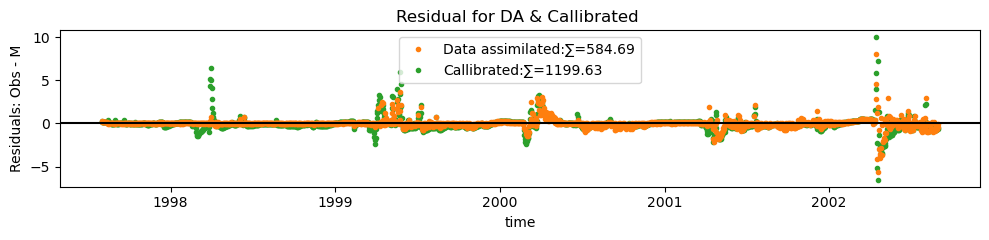

In [170]:
fig, ds_lst = generate_plots(df, '04057800')
fig = plot_residuals(ds_lst)

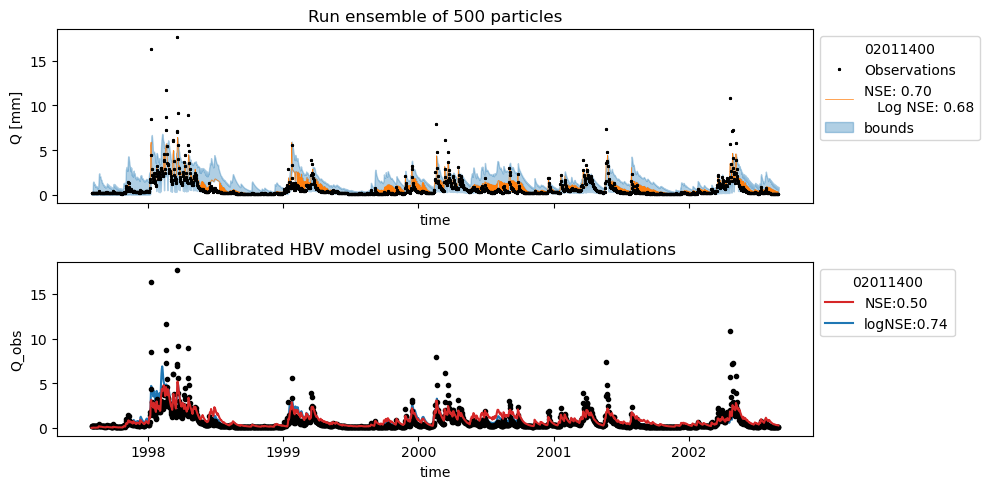

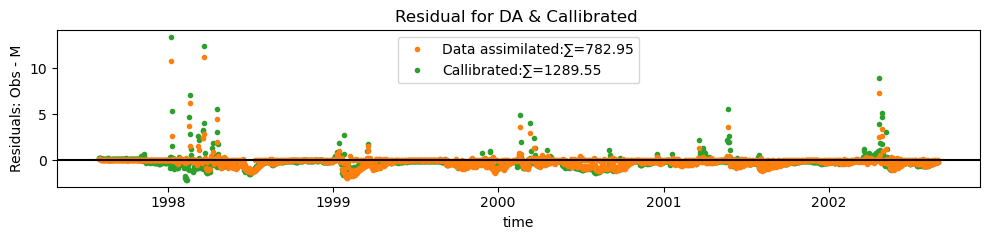

In [171]:
fig, ds_lst = generate_plots(df, '02011400')
fig = plot_residuals(ds_lst)

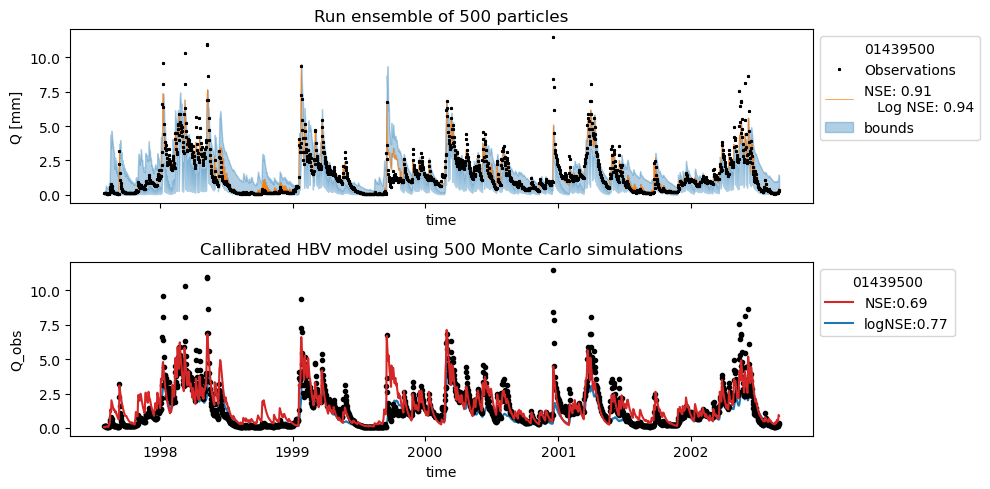

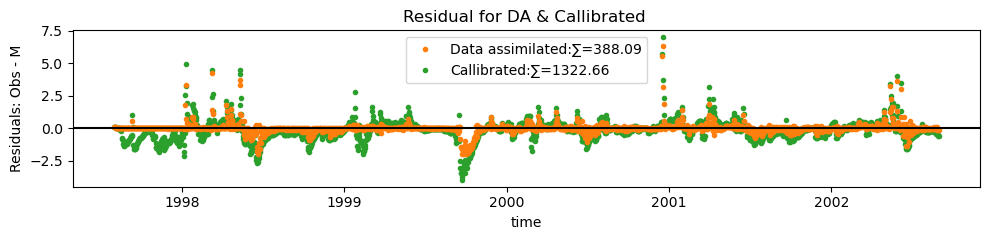

In [172]:
fig, ds_lst = generate_plots(df, '01439500')
fig = plot_residuals(ds_lst)

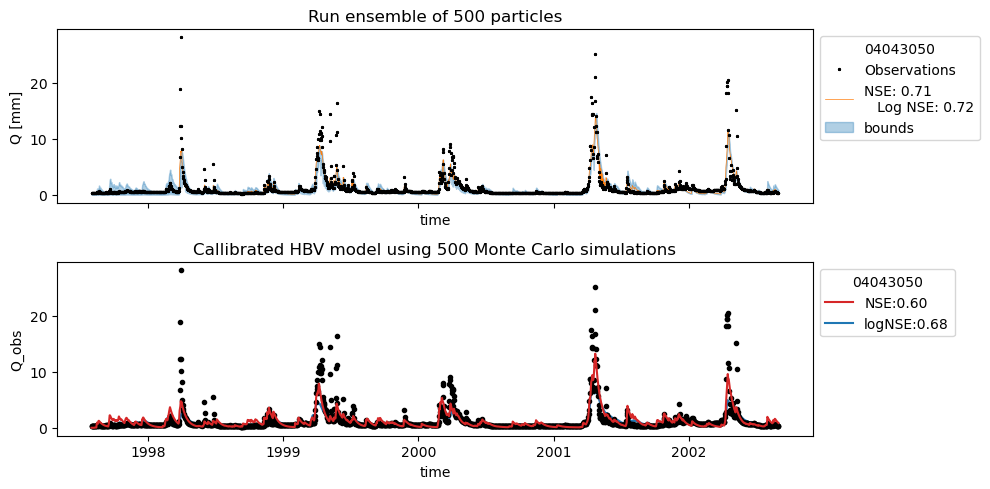

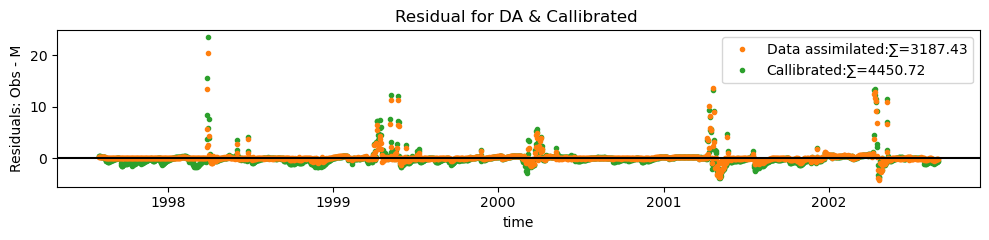

In [173]:
# 3479000
fig, ds_lst = generate_plots(df, '04043050')
fig = plot_residuals(ds_lst)

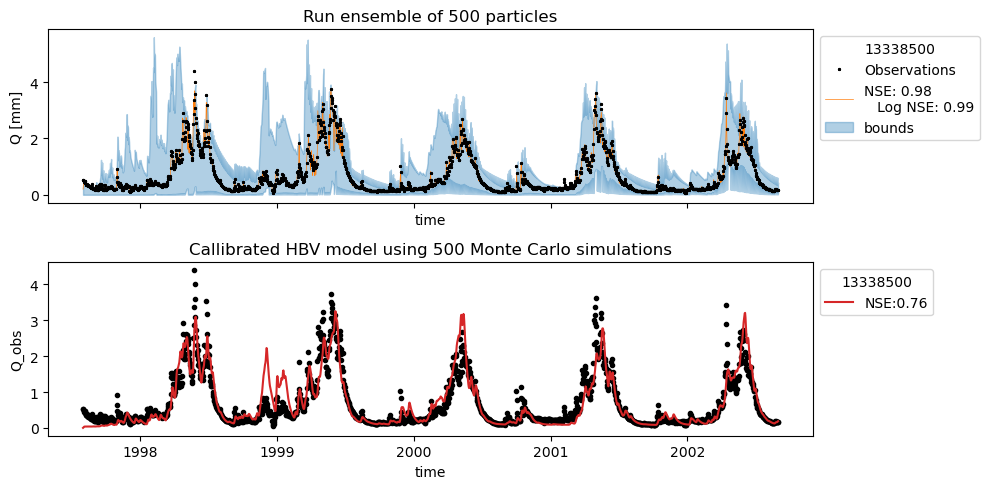

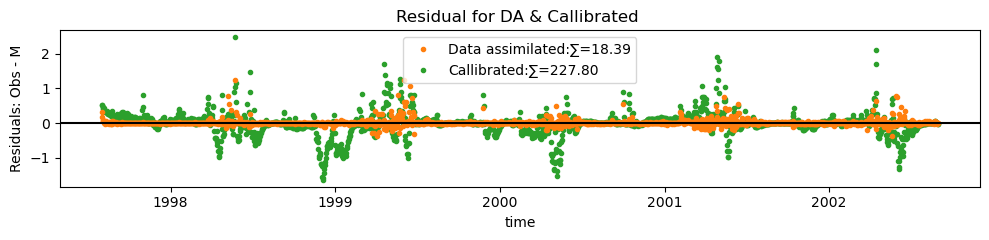

In [174]:
fig, ds_lst = generate_plots(df, '13338500')
fig = plot_residuals(ds_lst)
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

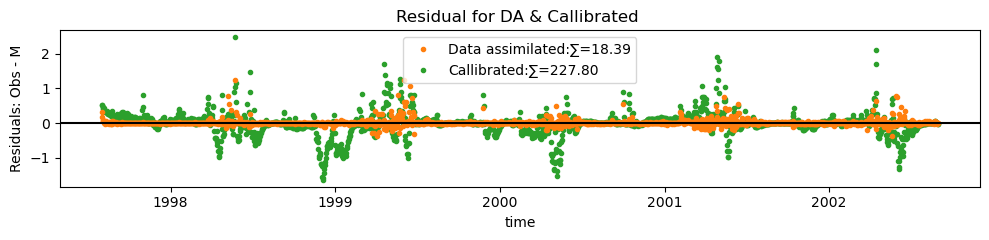

In [39]:
fig = plot_residuals(ds_lst)

In [40]:
### fig, ds_lst= generate_plots(df, '02314500')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

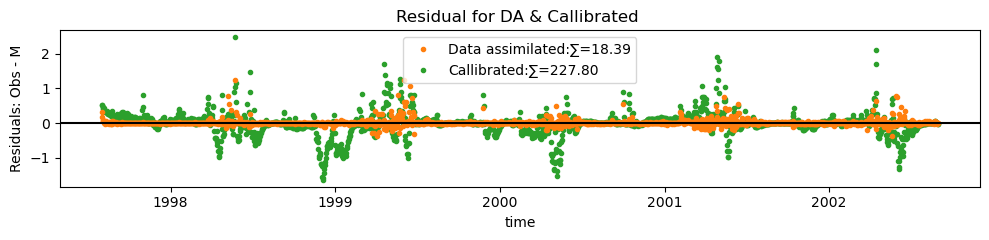

In [41]:
fig = plot_residuals(ds_lst)

In [42]:
# fig, ds_lst = generate_plots(df, '01586610')
# # fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
# fig, ds_lst = plot_residuals(ds_lst)

In [43]:
# fig, ds_lst = generate_plots(df, '02193340')
# # fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
# fig2 = plot_residuals(ds_lst)

In [44]:
# fig, ds_lst = generate_plots(df, '01013500')
# # fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
# fig2 = plot_residuals(ds_lst)
# # fig2.savefig(figure_path / f"Residuals for DA run vs callibrated value for {ds_lst[0].attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

## 01073000

In [67]:
# fig, ds_lst= generate_plots(df, '01052500')


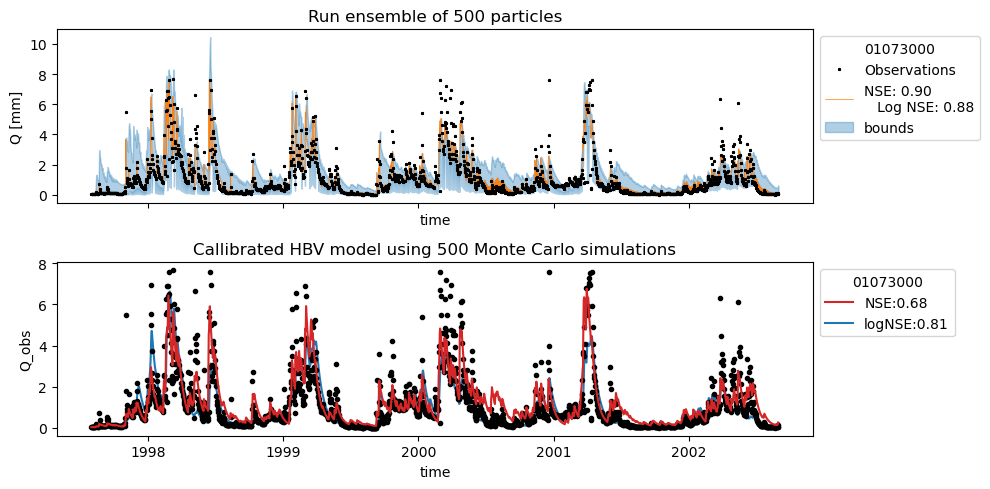

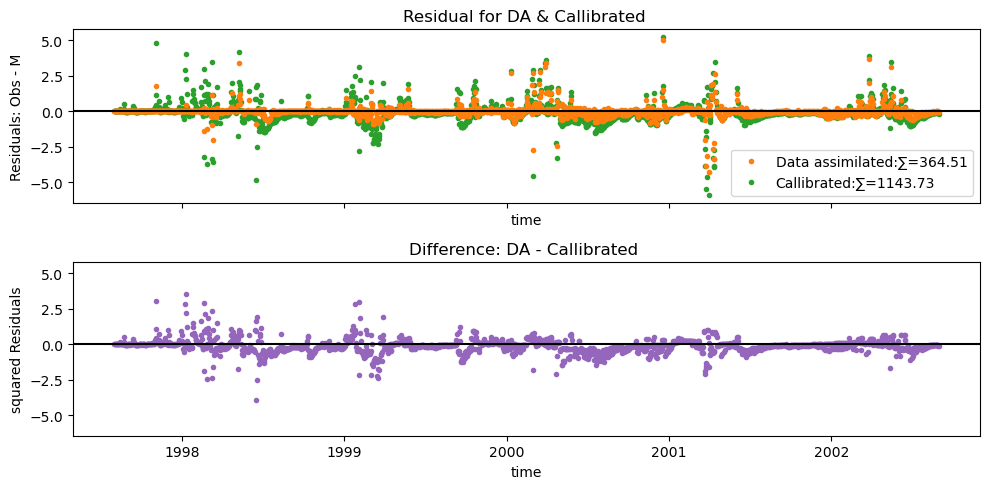

In [45]:
fig, ds_lst= generate_plots(df, '01073000')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
fig2, ds_lst = plot_residuals(ds_lst,diff=True)
# fig2.savefig(figure_path / f"Residuals for DA run vs callibrated value for {ds_lst[0].attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

### investigate a post - flood 

In [46]:
ds0, ds1 = ds_lst
t_index = (ds0.time > np.datetime64('2000-01-01')) & (ds0.time < np.datetime64('2000-09-01')).values
ds_lst = [ds0.sel(time=t_index), ds1.sel(time=t_index)]

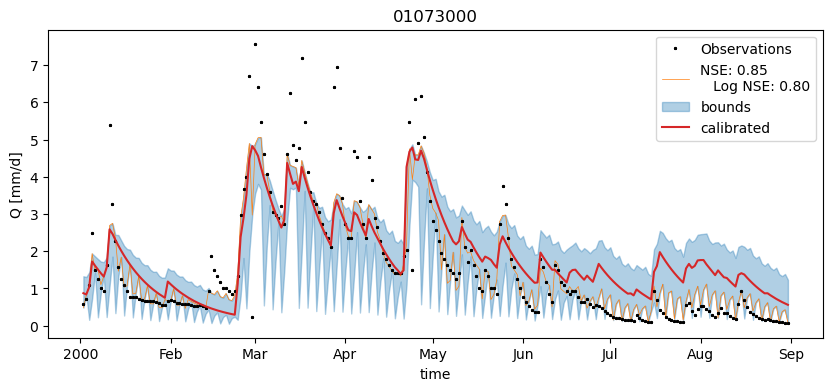

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
plot_hydrograph(ds_lst[0], ax, summary_stat='best')
ds_lst[1]['Q'].plot(ax=ax,color='C3',label='calibrated')
ax.legend()
ax.set_title(f'{ds_lst[0].attrs["HRU_id"]}');

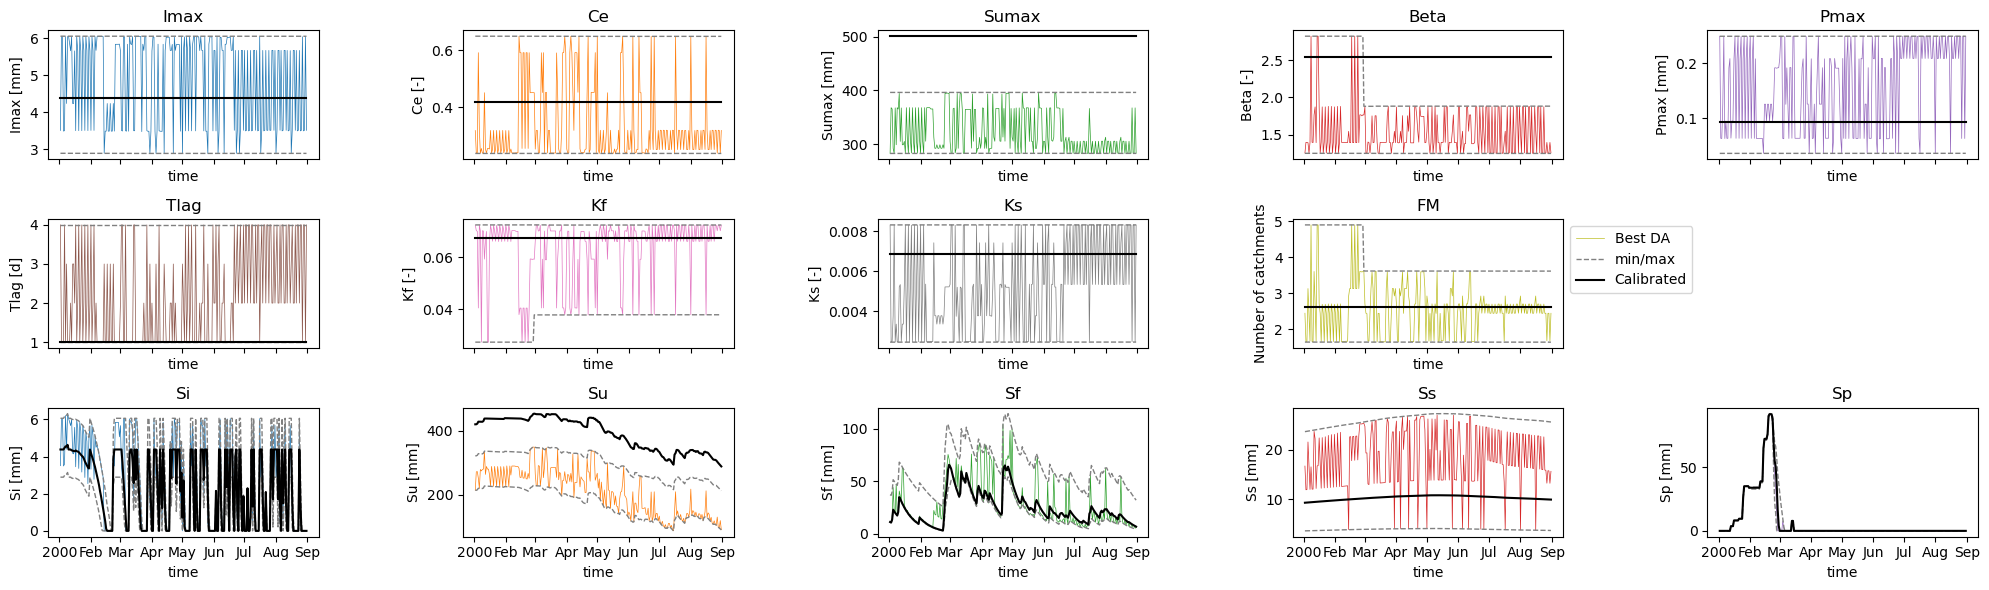

In [48]:
fig, ax = plt.subplots(3,5, figsize=(20,6),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names
plot_params(names,ds_lst,ax)
fig.tight_layout()

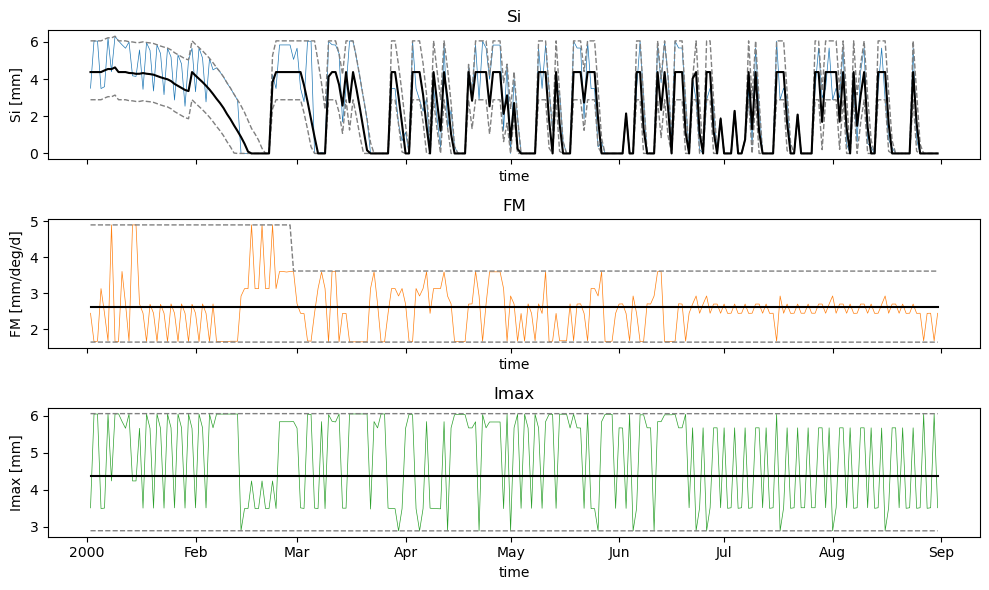

In [49]:
names = ['Si','FM','Imax']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()
plot_params(names, ds_lst, ax)
fig.tight_layout()

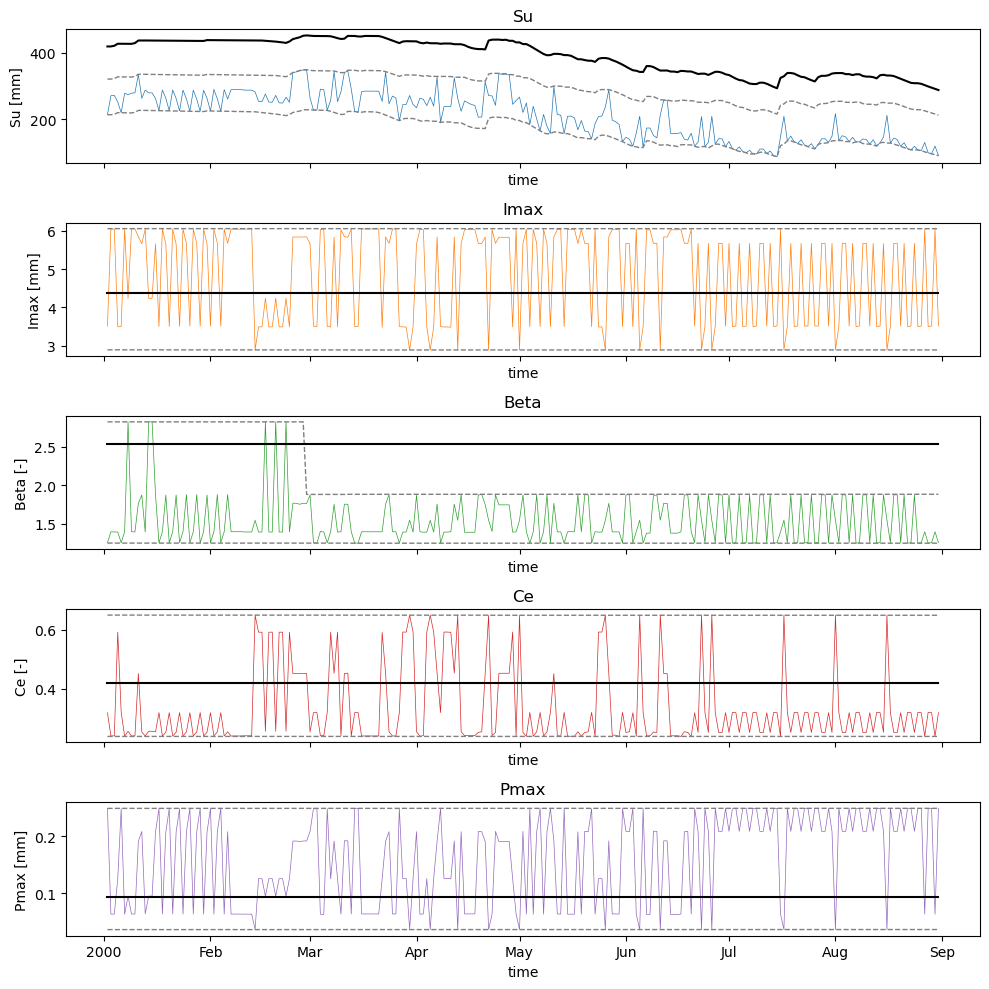

In [50]:
names = ['Su','Imax','Beta','Ce','Pmax']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst,ax)
fig.tight_layout()

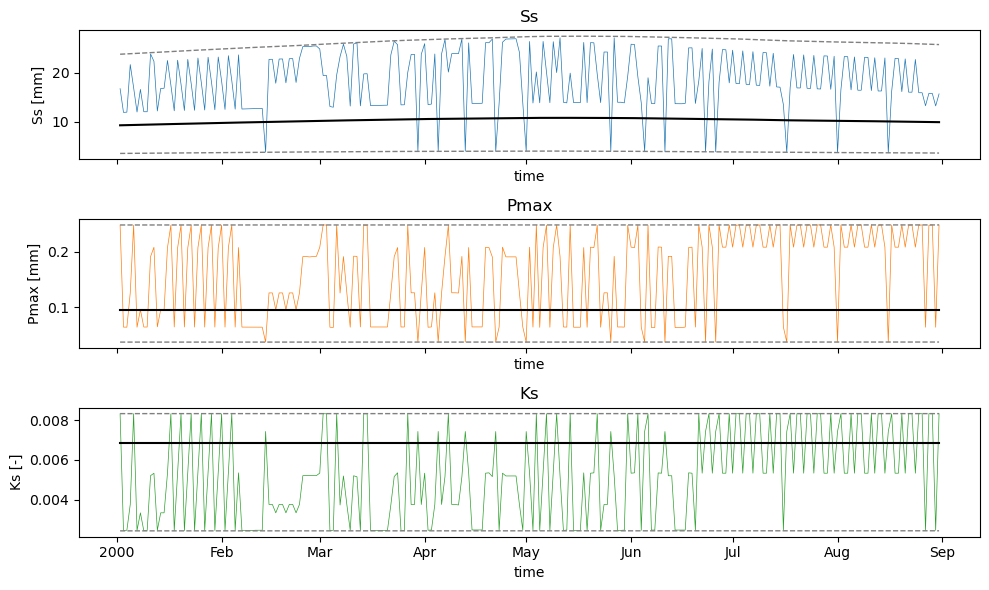

In [51]:
names = ['Ss','Pmax','Ks']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst,ax)
fig.tight_layout()

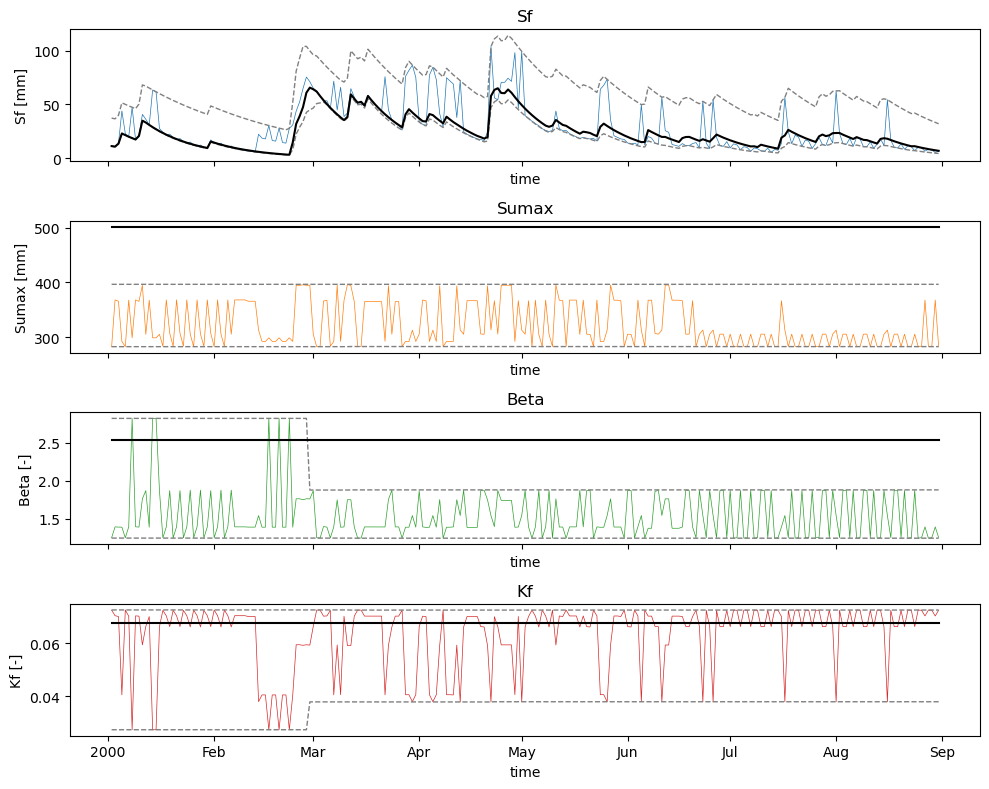

In [52]:
names = ['Sf','Sumax','Beta','Kf']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst,ax)
fig.tight_layout()

### investigate missed flood peak

In [53]:
fig, ds_lst= generate_plots(df, '01073000')
fig2, ds_lst = plot_residuals(ds_lst,diff=True)
plt.close(fig)
plt.close(fig2)

ds0, ds1 = ds_lst
t_index = (ds0.time > np.datetime64('1998-04-01')) & (ds0.time < np.datetime64('1998-10-01')).values
ds_lst = [ds0.sel(time=t_index), ds1.sel(time=t_index)]

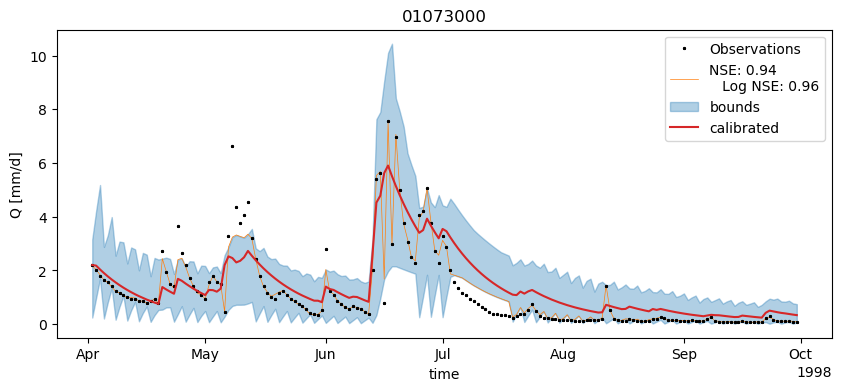

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
plot_hydrograph(ds_lst[0], ax, summary_stat='best')
ds_lst[1]['Q'].plot(ax=ax,color='C3',label='calibrated')
ax.legend()
ax.set_title(f'{ds_lst[0].attrs["HRU_id"]}');

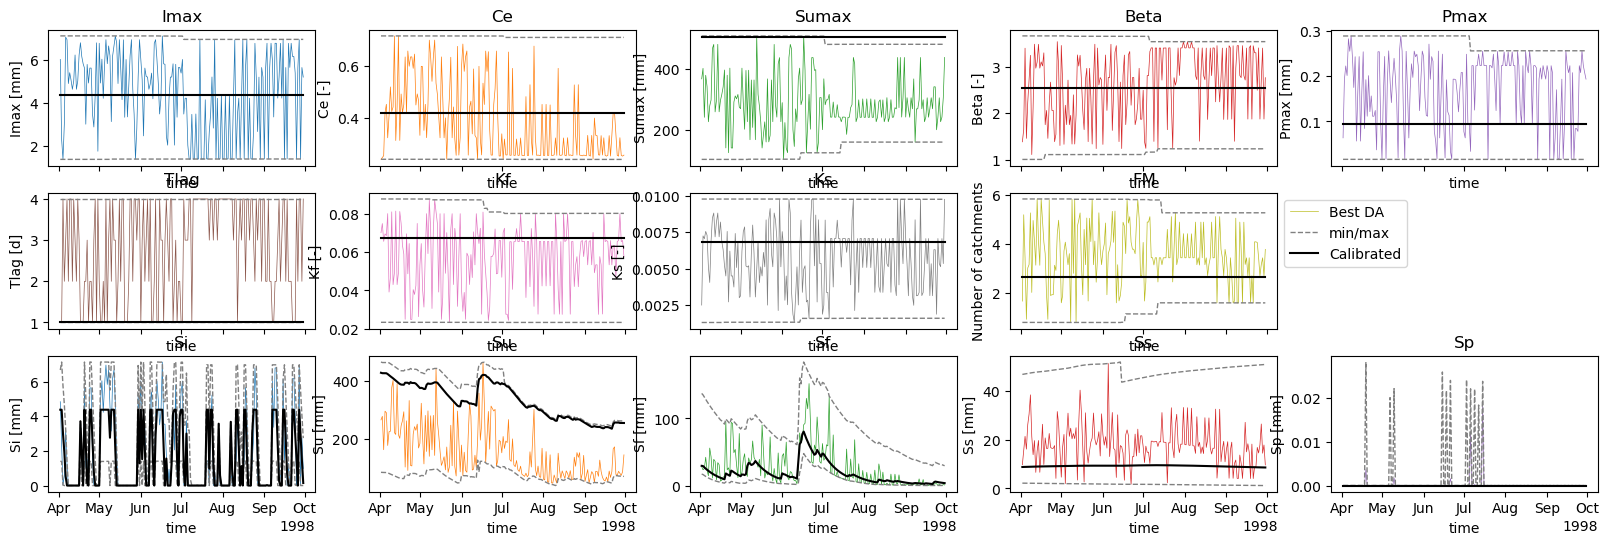

In [55]:
fig, ax = plt.subplots(3,5, figsize=(20,6),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names
plot_params(names, ds_lst, ax)

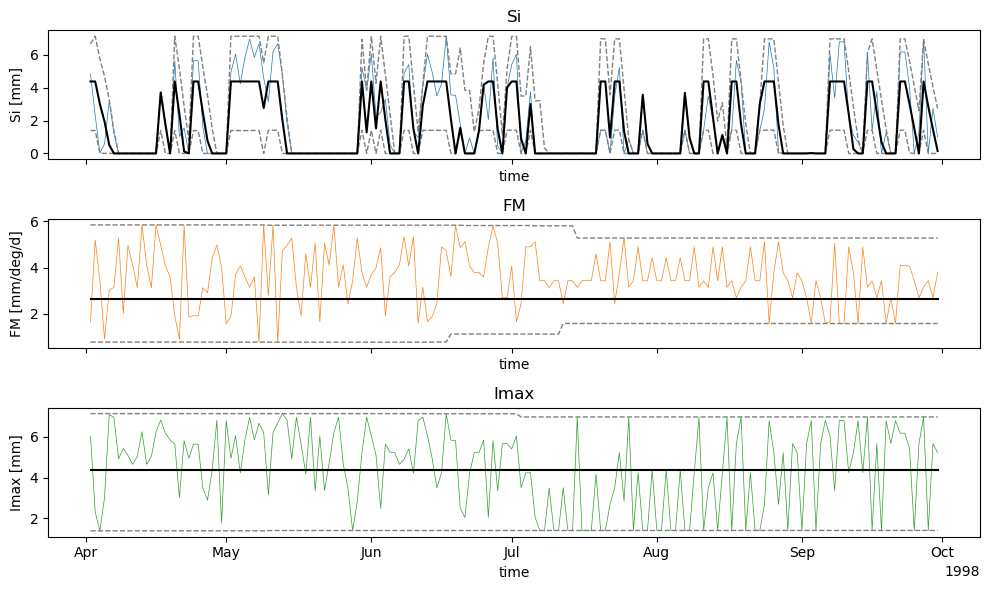

In [56]:
names = ['Si','FM','Imax']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()
plot_params(names, ds_lst, ax)
fig.tight_layout()

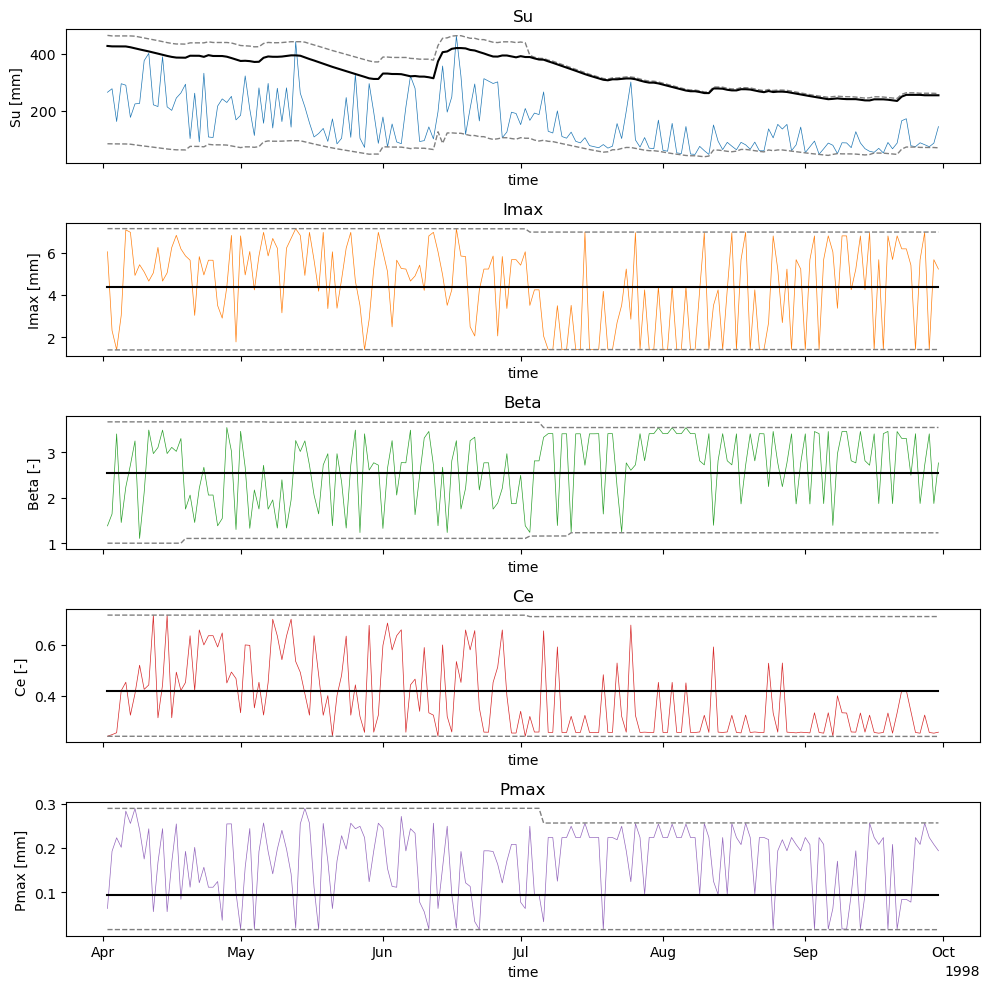

In [57]:
names = ['Su','Imax','Beta','Ce','Pmax']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst, ax)
fig.tight_layout()

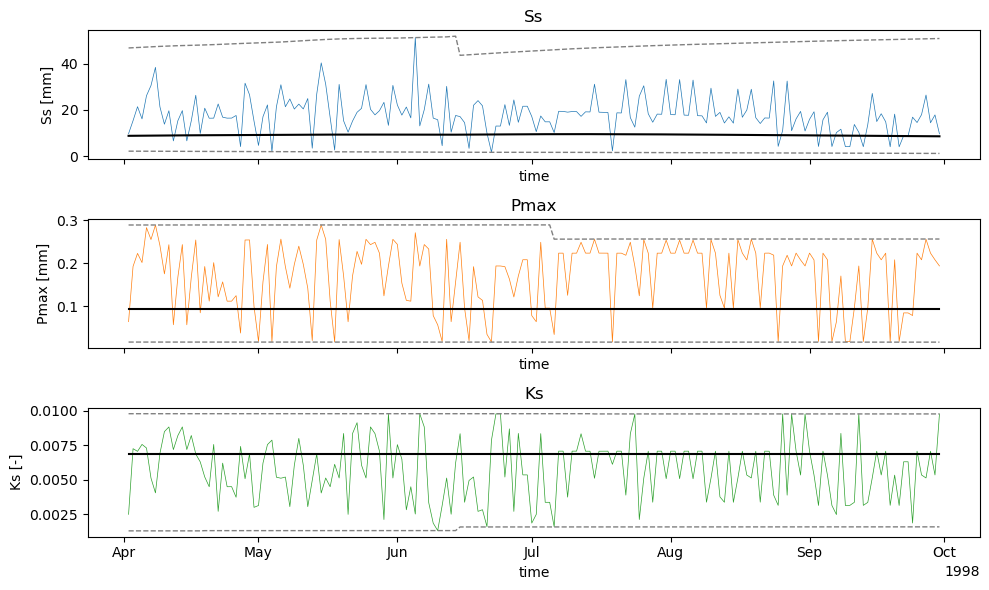

In [58]:
names = ['Ss','Pmax','Ks']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst, ax)
fig.tight_layout()

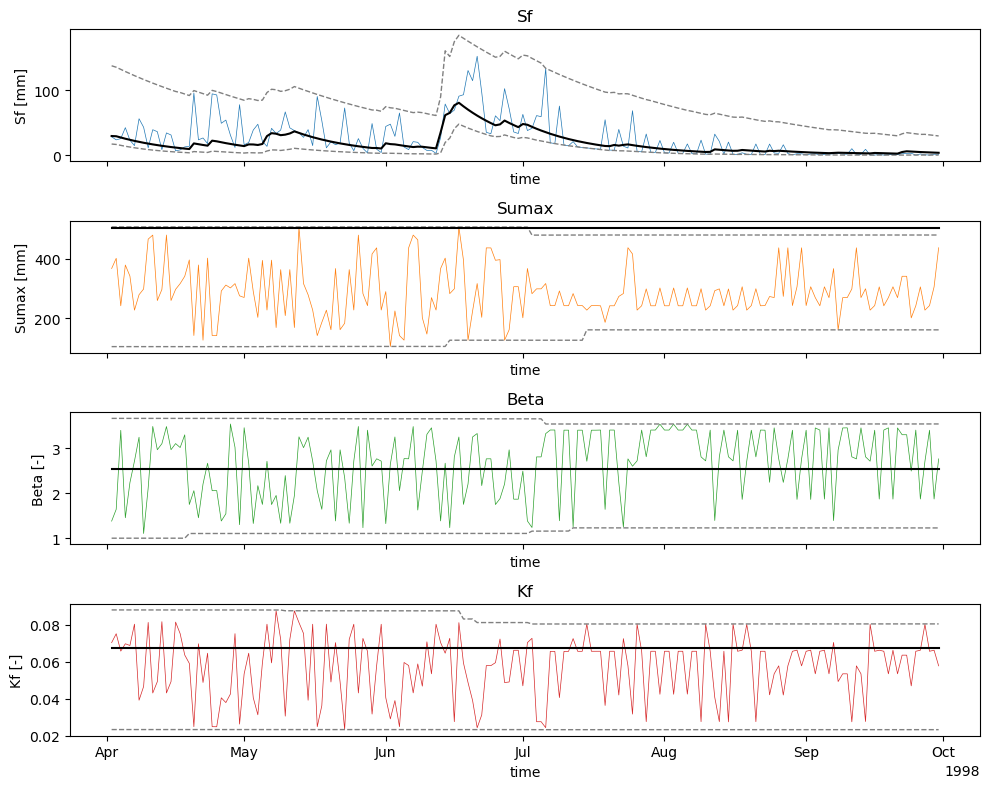

In [59]:
names = ['Sf','Sumax','Beta','Kf']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst, ax)
fig.tight_layout()

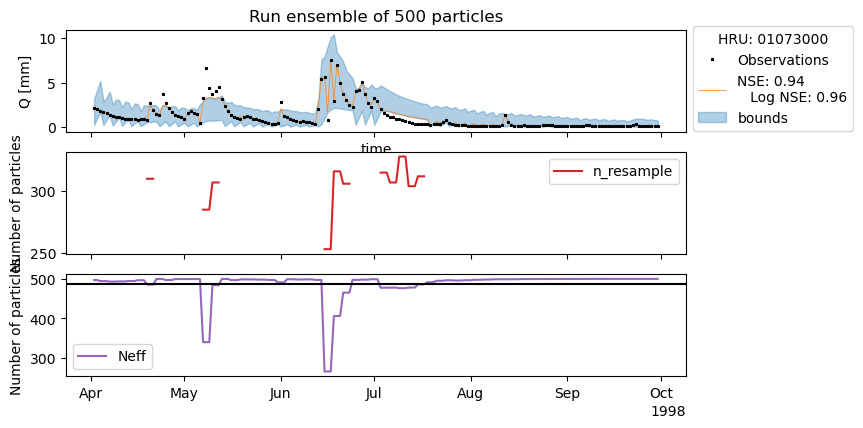

In [60]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_lst[0], ax[0], 'best')
ax[0].legend(title=f"HRU: {ds_lst[0].attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_lst[0]['time'].values, ds_lst[0][val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_lst[0].attrs['n_particles']*0.975, color='k');

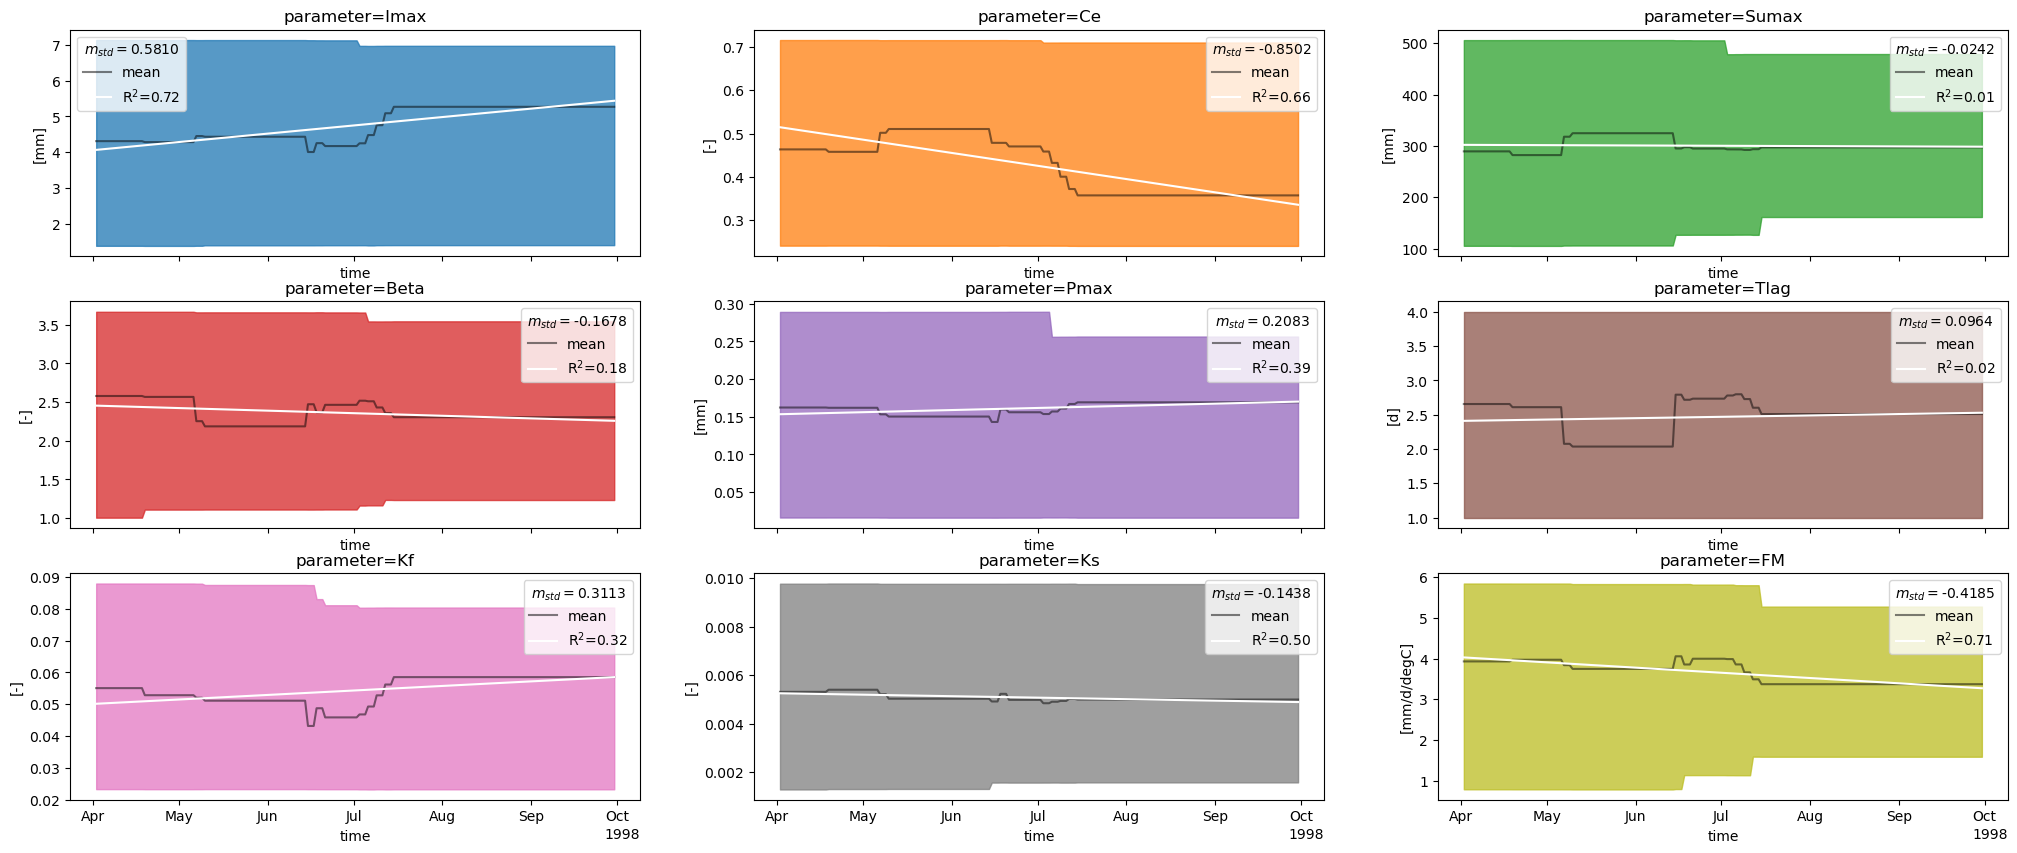

In [61]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
plot_params_slope(ds_lst[0], param_names,axs, regress=True)

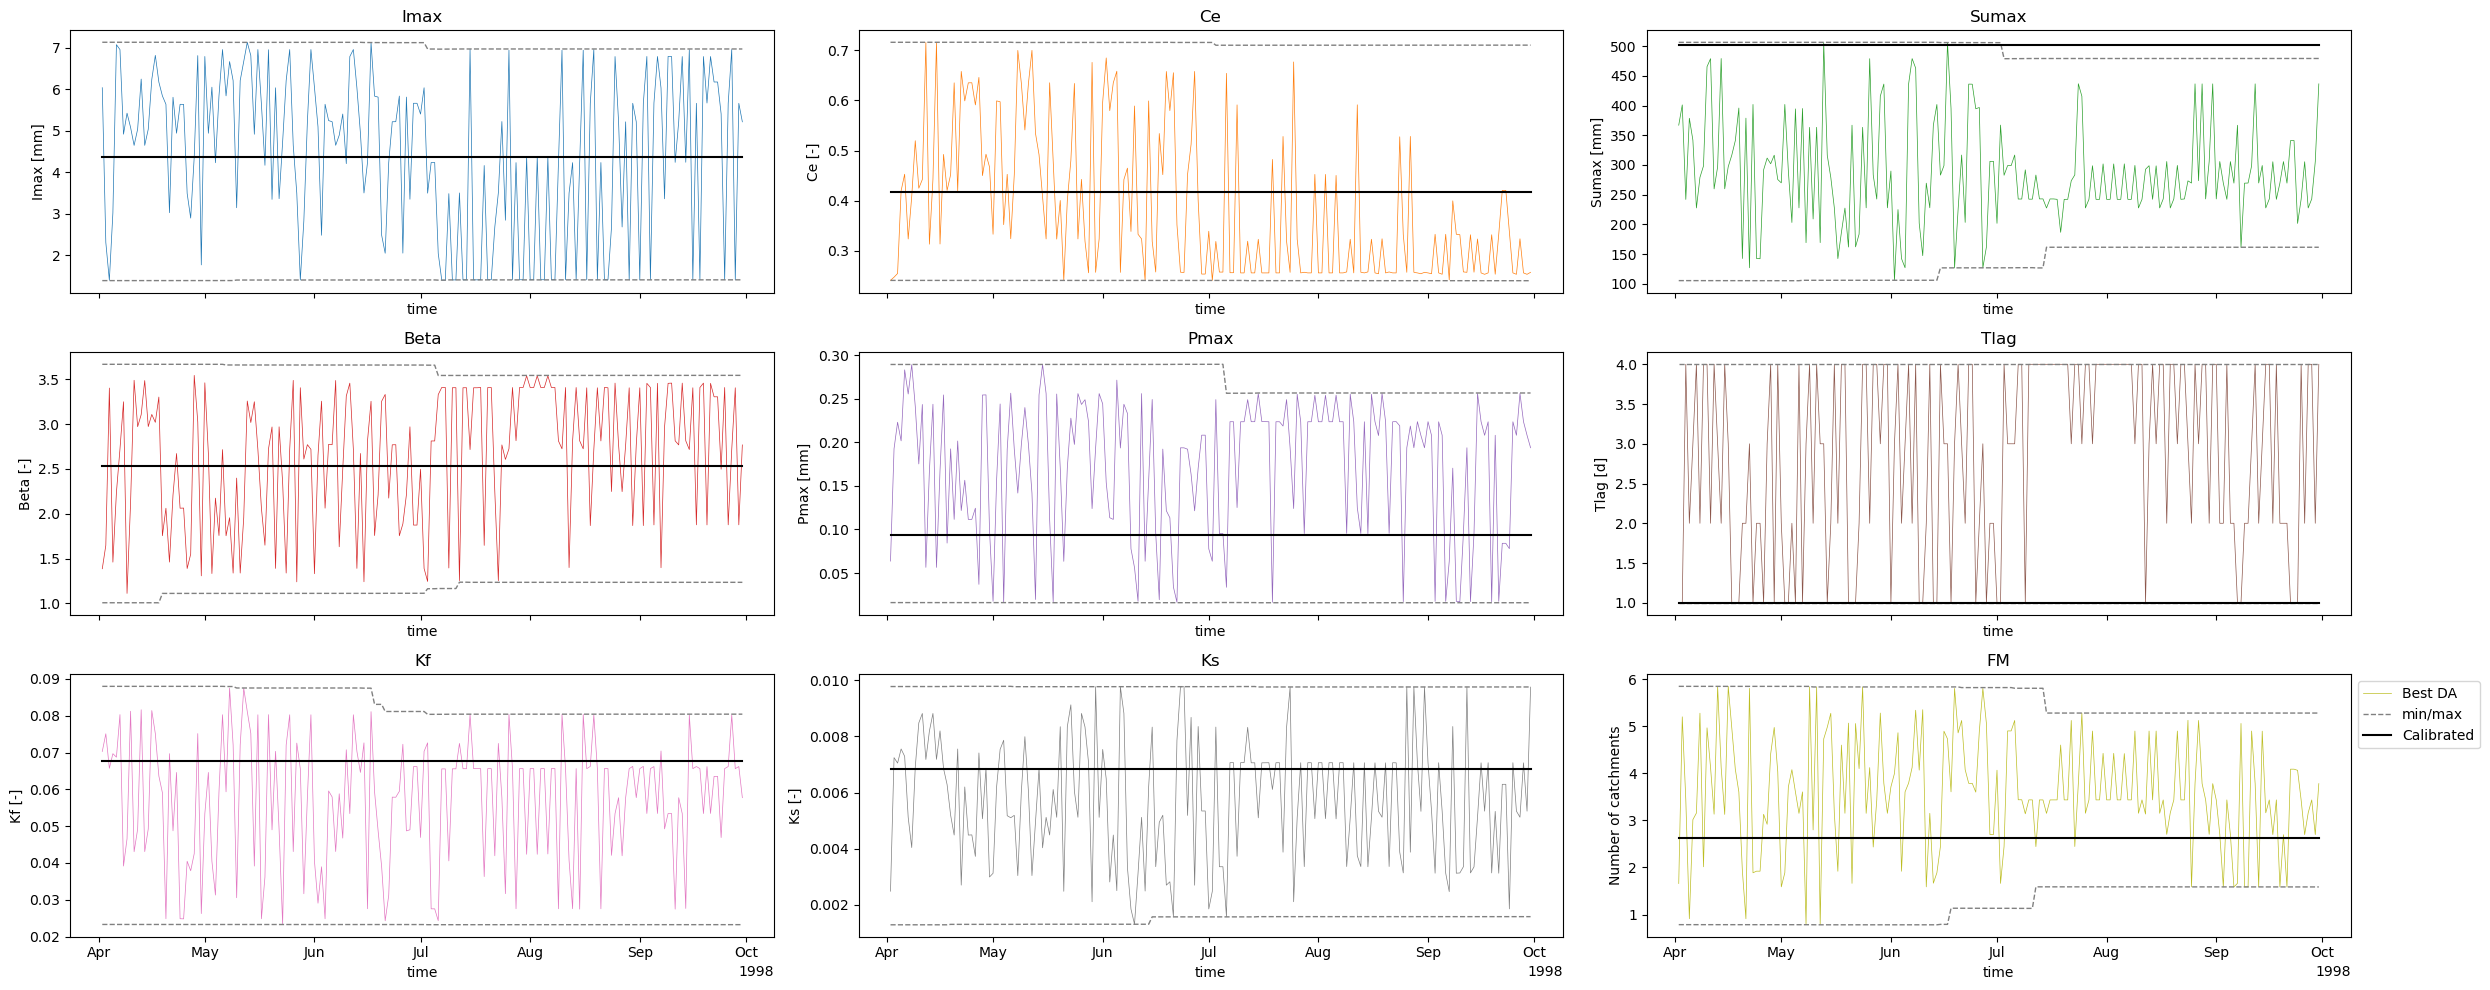

In [62]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
plot_params(param_names, ds_lst, axs)
fig.tight_layout()

# Using mean:

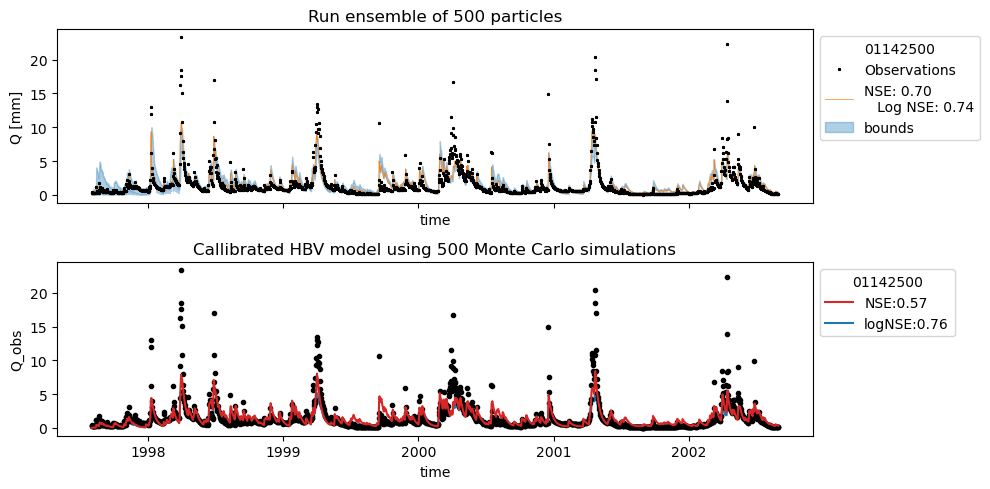

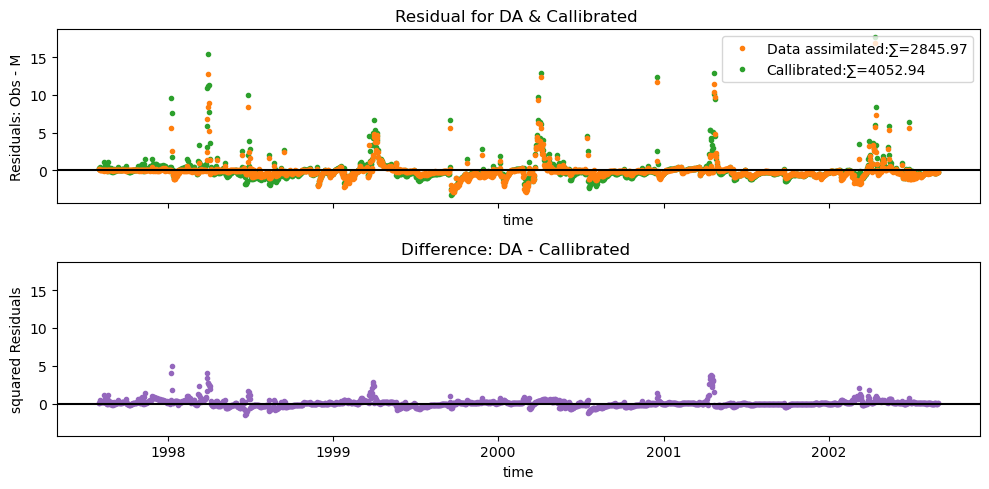

In [63]:
fig, ds_lst= generate_plots(df, '01142500')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
fig2 = plot_residuals(ds_lst, diff=True)


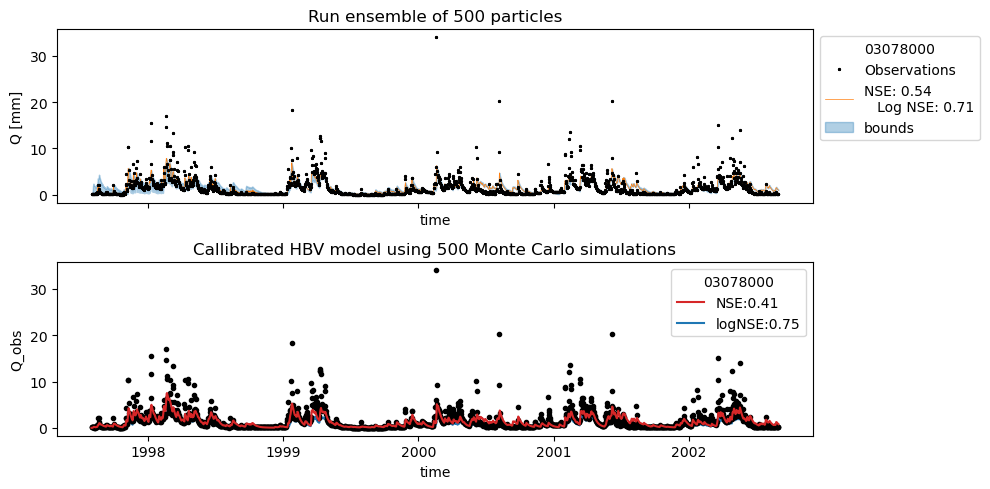

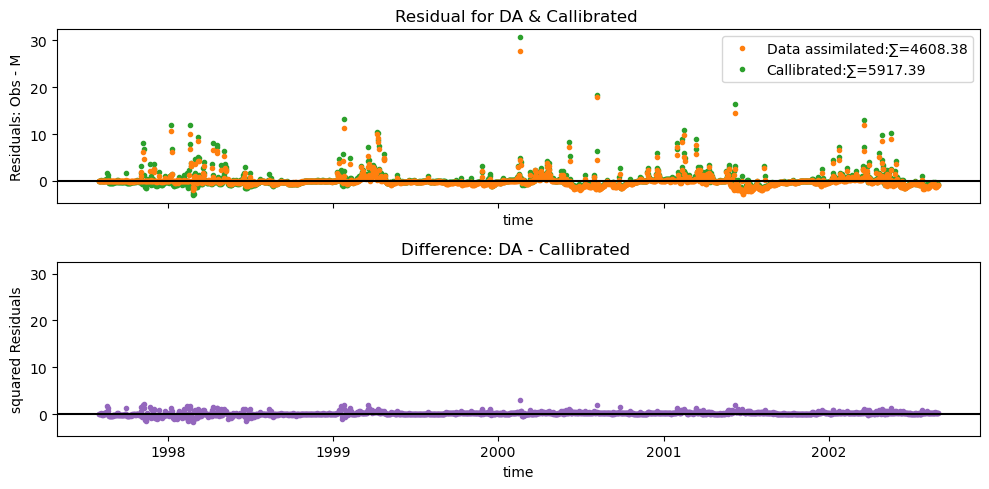

In [64]:
fig, ds_lst= generate_plots(df, '03078000')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
fig2 = plot_residuals(ds_lst, diff=True)


# Noise/errors in data? 

In [1]:
# fig, ds_lst= generate_plots(df, '11480390')


In [3]:
# fig, ds_lst= generate_plots(df, '01518862')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)